# NYC Restaurant Inspection Results

In [1]:
import pandas as pd
from sodapy import Socrata
from config import API_Key, username, password
import requests
import json
import matplotlib.pyplot as plt
import re, datetime

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.io import show, output_notebook
from bokeh.transform import dodge
from bokeh.core.properties import value

## 1. Loading Data from API

In [2]:
# Example authenticated client (needed for non-public datasets):
client = Socrata("data.cityofnewyork.us", API_Key, username, password)

# Returned as JSON from API by sodapy.
data = client.get("43nn-pn8j",limit=381912)

# Convert to pandas DataFrame
data_df = pd.DataFrame.from_records(data)

In [3]:
data_df.head(20)

,action,boro,building,camis,critical_flag,cuisine_description,dba,grade,grade_date,inspection_date,inspection_type,phone,record_date,score,street,violation_code,violation_description,zipcode
0,Violations were cited in the following area(s).,BRONX,1007,30075445,Not Critical,Bakery,MORRIS PARK BAKE SHOP,A,2018-05-11T00:00:00.000,2018-05-11T00:00:00.000,Cycle Inspection / Initial Inspection,7188924968,2019-05-01T06:00:34.000,5,MORRIS PARK AVE,08C,Pesticide use not in accordance with label or ...,10462
1,Violations were cited in the following area(s).,BRONX,1007,30075445,Not Critical,Bakery,MORRIS PARK BAKE SHOP,A,2018-05-11T00:00:00.000,2018-05-11T00:00:00.000,Cycle Inspection / Initial Inspection,7188924968,2019-05-01T06:00:34.000,5,MORRIS PARK AVE,10F,Non-food contact surface improperly constructe...,10462
2,Violations were cited in the following area(s).,BRONX,1007,30075445,Critical,Bakery,MORRIS PARK BAKE SHOP,A,2017-05-18T00:00:00.000,2017-05-18T00:00:00.000,Cycle Inspection / Initial Inspection,7188924968,2019-05-01T06:00:34.000,7,MORRIS PARK AVE,06D,"Food contact surface not properly washed, rins...",10462
3,Violations were cited in the following area(s).,BRONX,1007,30075445,Not Critical,Bakery,MORRIS PARK BAKE SHOP,A,2017-05-18T00:00:00.000,2017-05-18T00:00:00.000,Cycle Inspection / Initial Inspection,7188924968,2019-05-01T06:00:34.000,7,MORRIS PARK AVE,10F,Non-food contact surface improperly constructe...,10462
4,Violations were cited in the following area(s).,BRONX,1007,30075445,Critical,Bakery,MORRIS PARK BAKE SHOP,A,2016-02-18T00:00:00.000,2016-02-18T00:00:00.000,Cycle Inspection / Initial Inspection,7188924968,2019-05-01T06:00:34.000,10,MORRIS PARK AVE,04L,Evidence of mice or live mice present in facil...,10462
5,Violations were cited in the following area(s).,BRONX,1007,30075445,Not Critical,Bakery,MORRIS PARK BAKE SHOP,A,2016-02-18T00:00:00.000,2016-02-18T00:00:00.000,Cycle Inspection / Initial Inspection,7188924968,2019-05-01T06:00:34.000,10,MORRIS PARK AVE,08A,Facility not vermin proof. Harborage or condit...,10462
6,Violations were cited in the following area(s).,BROOKLYN,469,30112340,Critical,Hamburgers,WENDY'S,A,2019-03-04T00:00:00.000,2019-03-04T00:00:00.000,Cycle Inspection / Initial Inspection,7182875005,2019-05-01T06:00:34.000,13,FLATBUSH AVENUE,02G,Cold food item held above 41Âº F (smoked fish ...,11225
7,Violations were cited in the following area(s).,BROOKLYN,469,30112340,Not Critical,Hamburgers,WENDY'S,A,2019-03-04T00:00:00.000,2019-03-04T00:00:00.000,Cycle Inspection / Initial Inspection,7182875005,2019-05-01T06:00:34.000,13,FLATBUSH AVENUE,10B,Plumbing not properly installed or maintained;...,11225
8,Violations were cited in the following area(s).,BROOKLYN,469,30112340,Not Critical,Hamburgers,WENDY'S,A,2019-03-04T00:00:00.000,2019-03-04T00:00:00.000,Cycle Inspection / Initial Inspection,7182875005,2019-05-01T06:00:34.000,13,FLATBUSH AVENUE,10F,Non-food contact surface improperly constructe...,11225
9,Violations were cited in the following area(s).,BROOKLYN,469,30112340,Critical,Hamburgers,WENDY'S,A,2018-03-13T00:00:00.000,2018-03-13T00:00:00.000,Cycle Inspection / Initial Inspection,7182875005,2019-05-01T06:00:34.000,12,FLATBUSH AVENUE,04L,Evidence of mice or live mice present in facil...,11225


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381698 entries, 0 to 381697
Data columns (total 18 columns):
action                   380361 non-null object
boro                     381698 non-null object
building                 381476 non-null object
camis                    381698 non-null object
critical_flag            381698 non-null object
cuisine_description      381698 non-null object
dba                      381189 non-null object
grade                    192284 non-null object
grade_date               189749 non-null object
inspection_date          381698 non-null object
inspection_type          380361 non-null object
phone                    381689 non-null object
record_date              381698 non-null object
score                    363480 non-null object
street                   381698 non-null object
violation_code           375872 non-null object
violation_description    373270 non-null object
zipcode                  376151 non-null object
dtypes: object(18)
memory

## 2. Violations Count by Year and Boroughs

In [5]:
violation_count = data_df.groupby(['inspection_date','boro'])['violation_code'].count()
violation_count = pd.DataFrame(violation_count)
violation_count = violation_count.reset_index()
violation_count = violation_count.loc[violation_count['boro']!='Missing']
violation_count = violation_count.rename(columns={"violation_code": "violation_count"})
violation_count.head()

,inspection_date,boro,violation_count
0,1900-01-01T00:00:00.000,BRONX,0
1,1900-01-01T00:00:00.000,BROOKLYN,0
2,1900-01-01T00:00:00.000,MANHATTAN,0
4,1900-01-01T00:00:00.000,QUEENS,0
5,1900-01-01T00:00:00.000,STATEN ISLAND,0


In [6]:
output_notebook()

Loading BokehJS ...

In [7]:
violation = violation_count.copy()
violation = violation.pivot(index='inspection_date',columns='boro',values='violation_count')
violation = violation.dropna()
violation = violation.reset_index()
violation.head()

boro,inspection_date,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
0,1900-01-01T00:00:00.000,0.0,0.0,0.0,0.0,0.0
1,2015-04-16T00:00:00.000,0.0,6.0,8.0,3.0,5.0
2,2015-04-17T00:00:00.000,3.0,8.0,20.0,4.0,2.0
3,2015-04-30T00:00:00.000,2.0,6.0,14.0,15.0,1.0
4,2015-05-05T00:00:00.000,4.0,1.0,14.0,5.0,4.0


In [8]:
boros = list(violation_count['boro'].unique())

boro_data = []
for boro in boros:
    borough = violation_count.loc[violation_count['boro']==boro]['violation_count']
    boro_data.append(borough)
    
boros

['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND']

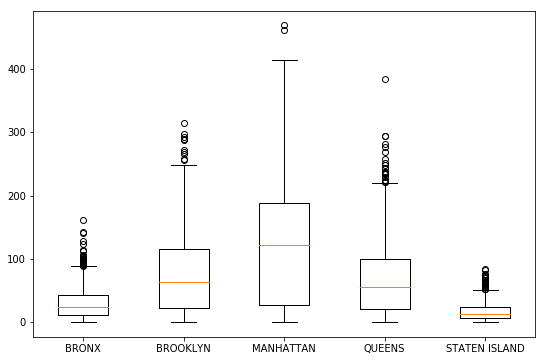

In [9]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(boro_data)

# Add tickers
ax.set_xticklabels(boros)

# Save the figure #fig.savefig('fig1.png', bbox_inches='tight')
plt.show()

In [10]:
cuisine_count = data_df.groupby(['cuisine_description'])[['dba','violation_code']].count()
#cuisine_count = pd.DataFrame(violation_count)
#cuisine_count = violation_count.reset_index()
cuisine_count

,dba,violation_code
cuisine_description,,
Afghan,168,166
African,1594,1572
American,82327,81209
Armenian,279,273
Asian,6039,5982
Australian,329,326
Bagels/Pretzels,2724,2693
Bakery,11598,11461
Bangladeshi,1066,1049


## 4. Mapping with folium

In [22]:
map_df = data_df.groupby(['boro','zipcode'])[['dba','inspection_type','violation_code']].count()
map_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 230 entries, (BRONX, 10451) to (STATEN ISLAND, 10314)
Data columns (total 3 columns):
dba                230 non-null int64
inspection_type    230 non-null int64
violation_code     230 non-null int64
dtypes: int64(3)
memory usage: 8.0+ KB
